In [1]:
import os, random, numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from sklearn.utils.class_weight import compute_class_weight
import warnings
warnings.filterwarnings('ignore')


In [2]:
base_dir = "/kaggle/input/chest-xray-pneumonia/chest_xray"
train_dir = os.path.join(base_dir, "train")
val_dir   = os.path.join(base_dir, "val")
test_dir  = os.path.join(base_dir, "test")

class_names = sorted([d for d in os.listdir(train_dir) if os.path.isdir(os.path.join(train_dir, d))])
print("Classes:", class_names)


Classes: ['NORMAL', 'PNEUMONIA']


In [3]:
class ChestXrayDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.samples = []

        self.class_to_idx = {class_name: i for i, class_name in enumerate(sorted(os.listdir(data_dir)))}

        for class_name, label in self.class_to_idx.items():
            class_path = os.path.join(data_dir, class_name)
            for img_name in os.listdir(class_path):
                img_path = os.path.join(class_path, img_name)
                self.samples.append((img_path, label))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label


In [4]:
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.RandomResizedCrop(224, scale=(0.9, 1.1)),  # zoom + shift approximation
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])


In [5]:
batch_size = 32

train_dataset = ChestXrayDataset(train_dir, transform=train_transform)
val_dataset   = ChestXrayDataset(val_dir,   transform=val_test_transform)
test_dataset  = ChestXrayDataset(test_dir,  transform=val_test_transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_dataset,   batch_size=batch_size, shuffle=False, num_workers=2)
test_loader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False, num_workers=2)


In [6]:
def count_images(data_dir):
    counts = {}
    total = 0
    for cls in class_names:
        cls_path = os.path.join(data_dir, cls)
        n = len([f for f in os.listdir(cls_path) if os.path.isfile(os.path.join(cls_path, f))])
        counts[cls] = n
        total += n
    return counts, total

train_counts, train_total = count_images(train_dir)
val_counts, val_total     = count_images(val_dir)
test_counts, test_total   = count_images(test_dir)

print("\nTrain samples:", train_total, train_counts)
print("Validation samples:", val_total, val_counts)
print("Test samples:", test_total, test_counts)



Train samples: 5216 {'NORMAL': 1341, 'PNEUMONIA': 3875}
Validation samples: 16 {'NORMAL': 8, 'PNEUMONIA': 8}
Test samples: 624 {'NORMAL': 234, 'PNEUMONIA': 390}


In [7]:
train_labels = [label for _, label in train_dataset]

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_labels),
    y=train_labels
)
class_weights = torch.tensor(class_weights, dtype=torch.float)
print("Class weights:", class_weights)

criterion = nn.CrossEntropyLoss(weight=class_weights)


Class weights: tensor([1.9448, 0.6730])


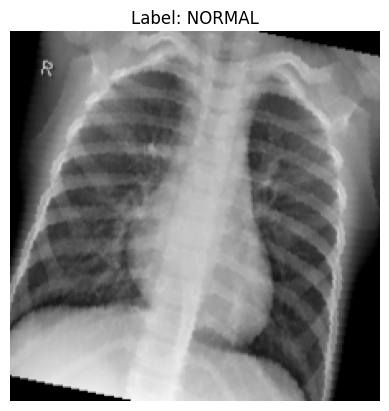

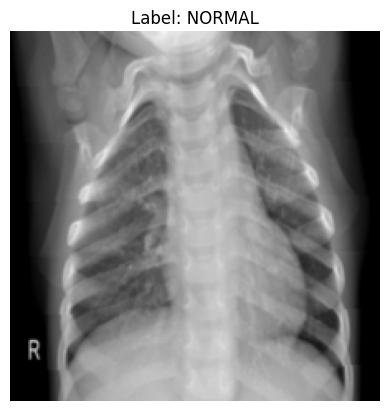

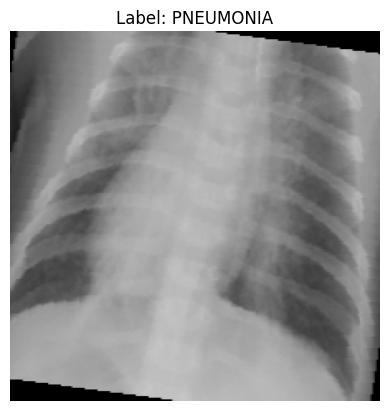

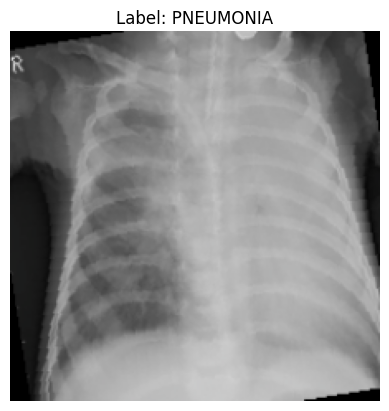

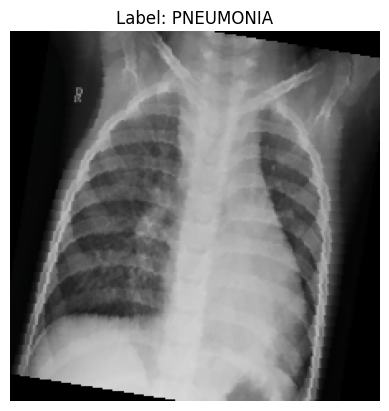

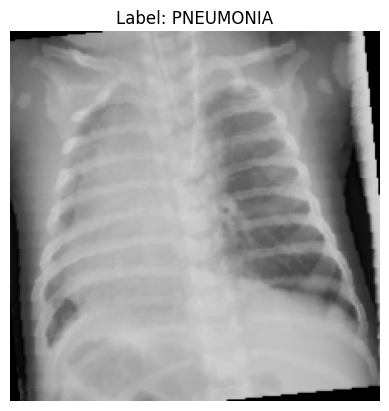

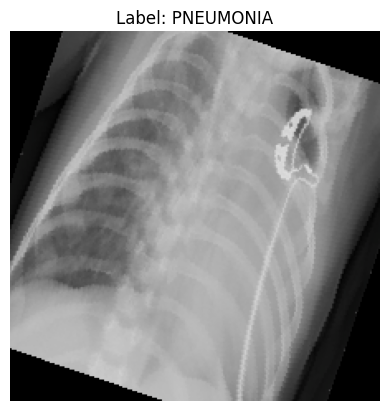

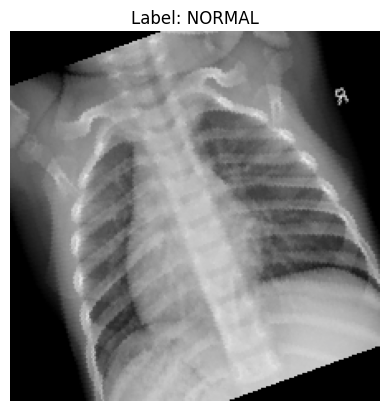

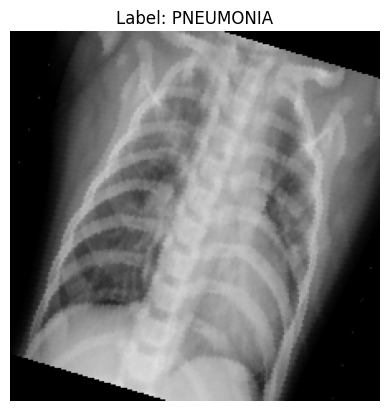

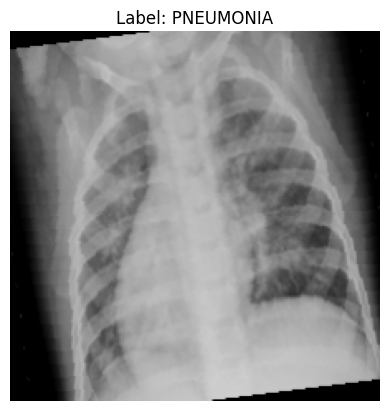

In [8]:
index_to_class = {v: k for k, v in train_dataset.class_to_idx.items()}

def display_images_from_dataset(dataset, n=10):
    for _ in range(n):
        idx = random.randint(0, len(dataset)-1)
        image, label = dataset[idx]
        image = image.permute(1, 2, 0).numpy()
        image = image * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]
        image = image.clip(0, 1)
        plt.imshow(image)
        plt.title(f"Label: {index_to_class[label]}")
        plt.axis('off')
        plt.show()

display_images_from_dataset(train_dataset, n=10)


<div style="
    border: 2px solid #FD7979;
    background: linear-gradient(135deg, #FFCDC9, #BB8ED0);
    padding: 12px 18px;
    border-radius: 10px;
    display: inline-flex;
    align-items: center;
    gap: 8px;
    box-shadow: 0 0 10px rgba(124, 131, 253, 0.3);
">
    <strong style="
        color:#301CA0;
        font-size: 20px;
        letter-spacing: 0.5px;
    ">
      ResNet50
    </strong>
    
</div>


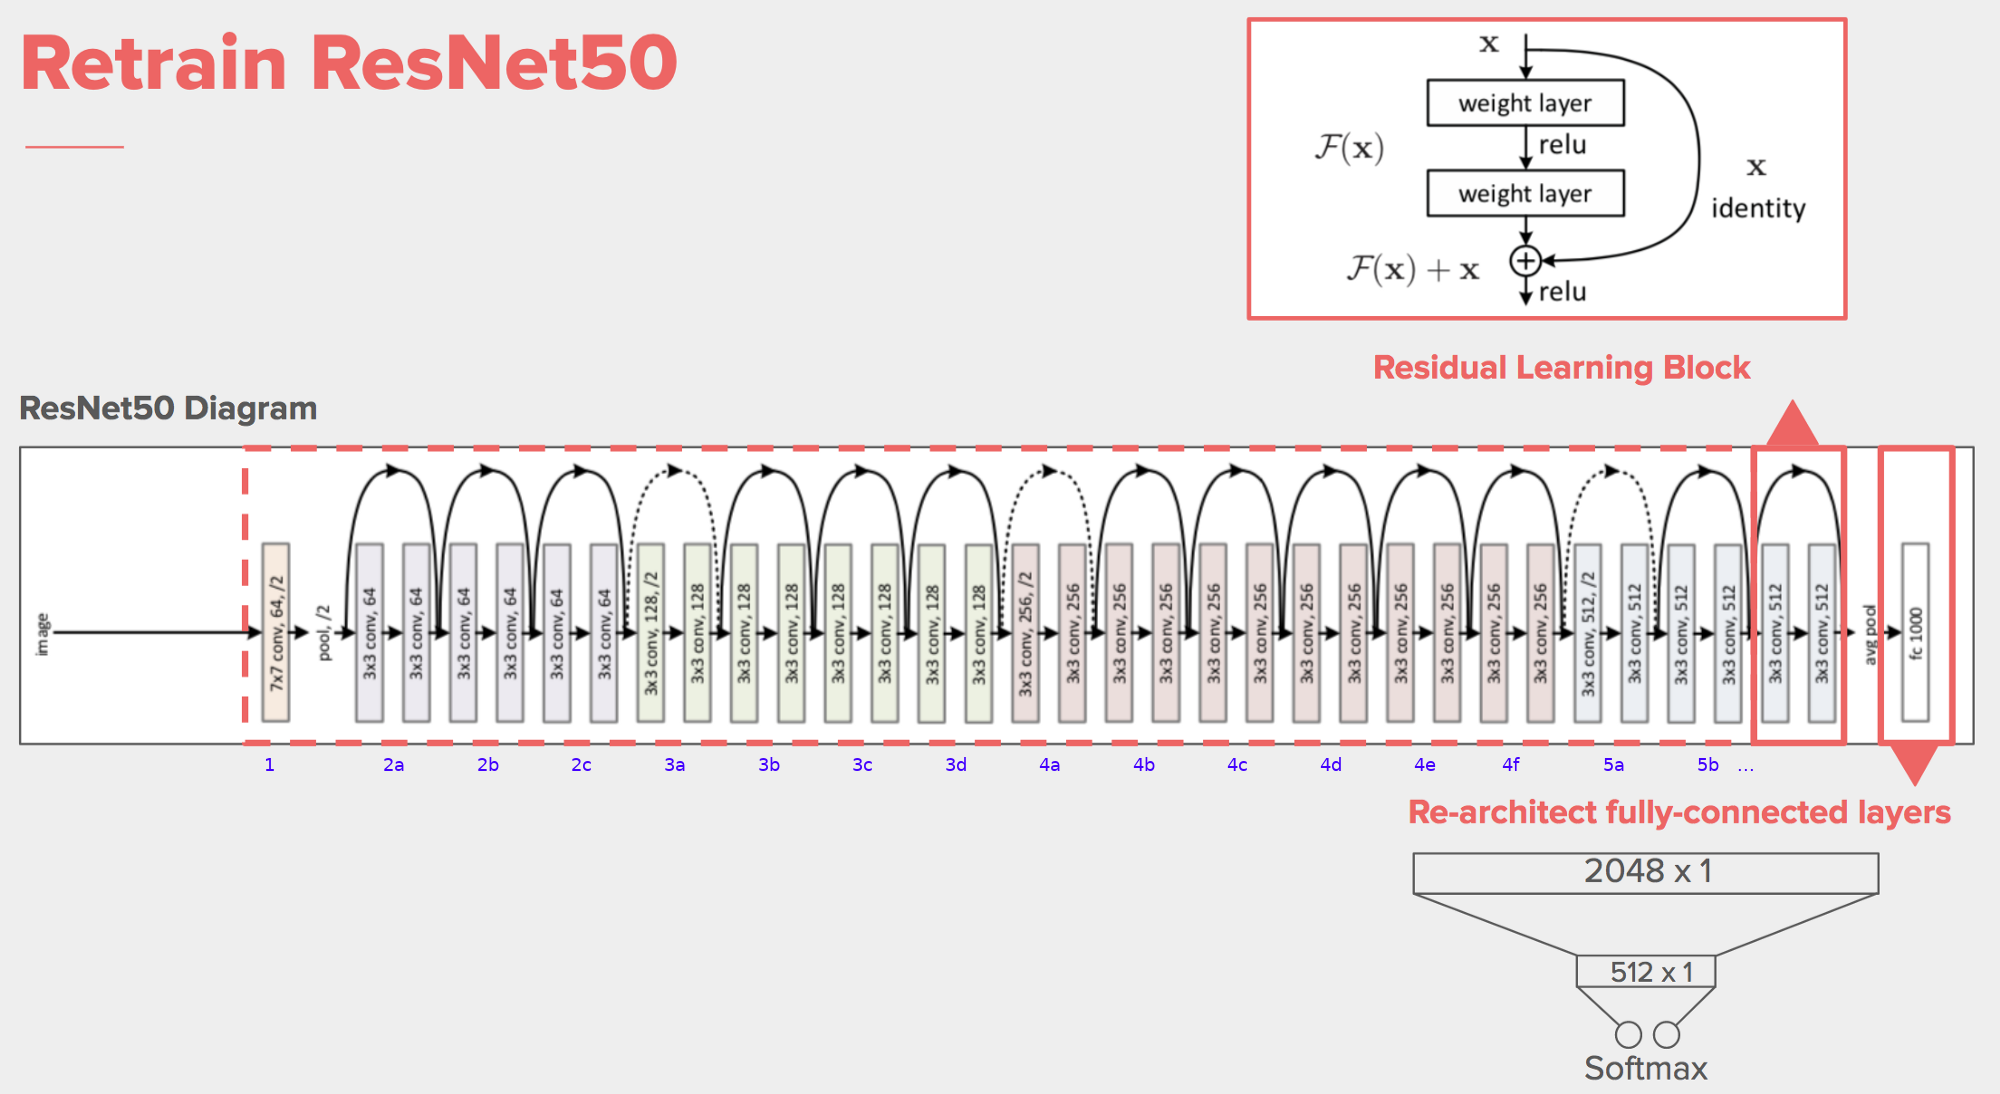

# STEP 1 : Load a pre-trained ResNet50 model and use it as a frozen feature extractor, then fine-tune and evaluate

## Load pre-trained ResNet50

In [9]:
import torch
from torchvision import models

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Load pretrained ResNet
resnet = models.resnet50(pretrained=True)

num_classes = len(class_names)

# Replace the final fully connected layer
resnet.fc = torch.nn.Linear(resnet.fc.in_features, num_classes)

resnet = resnet.to(device)

Using device: cuda
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 221MB/s]


## Freeze all layers except final layer (feature extractor)

In [10]:
for param in resnet.parameters():
    param.requires_grad = False

for param in resnet.fc.parameters():
    param.requires_grad = True


## Define Loss + Optimizer

In [11]:
import torch.optim as optim
import torch.nn as nn

criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))

optimizer = optim.Adam(resnet.fc.parameters(), lr=1e-3)


## Training Loop (Feature Extractor)

In [12]:
num_epochs = 10  

train_losses_frozen = []
val_losses_frozen   = []
train_accs_frozen   = []
val_accs_frozen     = []

all_labels_frozen = []
all_preds_frozen  = []
test_acc_frozen   = 0.0

for epoch in range(num_epochs):
    
    resnet.train()
    running_loss, correct, total = 0.0, 0, 0
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = resnet(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
    epoch_train_loss = running_loss / total
    epoch_train_acc  = correct / total
    train_losses_frozen.append(epoch_train_loss)
    train_accs_frozen.append(epoch_train_acc)
    
    resnet.eval()
    running_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = resnet(images)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
    epoch_val_loss = running_loss / total
    epoch_val_acc  = correct / total
    val_losses_frozen.append(epoch_val_loss)
    val_accs_frozen.append(epoch_val_acc)
    
    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Train Loss: {epoch_train_loss:.4f} Acc: {epoch_train_acc:.4f} | "
          f"Val Loss: {epoch_val_loss:.4f} Acc: {epoch_val_acc:.4f}")


Epoch [1/10] Train Loss: 0.3207 Acc: 0.8631 | Val Loss: 0.2930 Acc: 0.8750
Epoch [2/10] Train Loss: 0.1984 Acc: 0.9224 | Val Loss: 0.1704 Acc: 0.9375
Epoch [3/10] Train Loss: 0.1979 Acc: 0.9195 | Val Loss: 0.2107 Acc: 0.9375
Epoch [4/10] Train Loss: 0.1911 Acc: 0.9231 | Val Loss: 0.2386 Acc: 0.8750
Epoch [5/10] Train Loss: 0.2033 Acc: 0.9187 | Val Loss: 0.6416 Acc: 0.7500
Epoch [6/10] Train Loss: 0.1837 Acc: 0.9275 | Val Loss: 0.3425 Acc: 0.9375
Epoch [7/10] Train Loss: 0.1597 Acc: 0.9387 | Val Loss: 0.5296 Acc: 0.8750
Epoch [8/10] Train Loss: 0.1619 Acc: 0.9379 | Val Loss: 0.2042 Acc: 0.9375
Epoch [9/10] Train Loss: 0.1612 Acc: 0.9369 | Val Loss: 0.1674 Acc: 0.8750
Epoch [10/10] Train Loss: 0.1790 Acc: 0.9304 | Val Loss: 0.4365 Acc: 0.8750


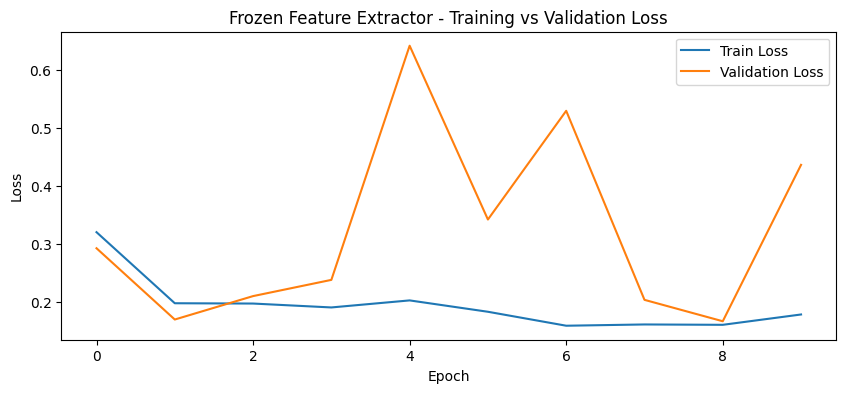

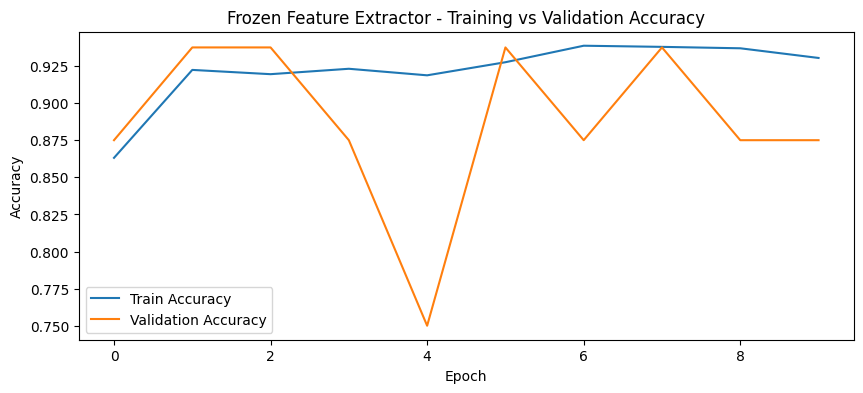

In [13]:
plt.figure(figsize=(10,4))
plt.plot(train_losses_frozen, label="Train Loss")
plt.plot(val_losses_frozen, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Frozen Feature Extractor - Training vs Validation Loss")
plt.legend()
plt.show()

plt.figure(figsize=(10,4))
plt.plot(train_accs_frozen, label="Train Accuracy")
plt.plot(val_accs_frozen, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Frozen Feature Extractor - Training vs Validation Accuracy")
plt.legend()
plt.show()

##  Evaluation for the model 

In [14]:
resnet.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = resnet(images)
        _, predicted = torch.max(outputs, 1)
        all_labels_frozen.extend(labels.cpu().numpy())
        all_preds_frozen.extend(predicted.cpu().numpy())

test_acc_frozen = sum(np.array(all_labels_frozen) == np.array(all_preds_frozen)) / len(all_labels_frozen)
print(f"Test Accuracy (Frozen Feature Extractor): {test_acc_frozen*100:.2f}%")



Test Accuracy (Frozen Feature Extractor): 85.74%


## Confusion Matrix + Classification Report

              precision    recall  f1-score   support

      NORMAL       0.90      0.70      0.79       234
   PNEUMONIA       0.84      0.95      0.89       390

    accuracy                           0.86       624
   macro avg       0.87      0.83      0.84       624
weighted avg       0.86      0.86      0.85       624



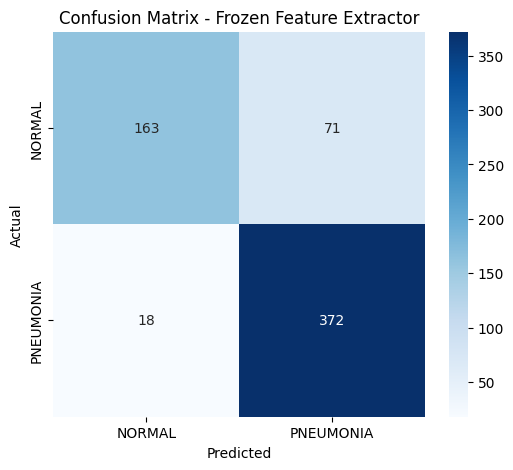

In [15]:


cm = confusion_matrix(all_labels_frozen, all_preds_frozen)
print(classification_report(all_labels_frozen, all_preds_frozen, target_names=class_names))

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=class_names, yticklabels=class_names, cmap="Blues")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.title("Confusion Matrix - Frozen Feature Extractor")
plt.show()

#  STEP 2 :Perform full fine-tuning of the model, then evaluate

## Unfreeze For All Layers

In [16]:
for param in resnet.parameters():
    param.requires_grad = True


## Optimizer For All Parameters

In [17]:
optimizer = optim.Adam(resnet.parameters(), lr=1e-4)  


## Training Loop (Full Fine-Tuning)

In [18]:
num_epochs = 15

train_losses_full = []
val_losses_full   = []
train_accs_full   = []
val_accs_full     = []

all_labels_full = []
all_preds_full  = []
test_acc_full   = 0.0

for epoch in range(num_epochs):
    
    resnet.train()
    running_loss, correct, total = 0.0, 0, 0
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = resnet(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
    epoch_train_loss = running_loss / total
    epoch_train_acc  = correct / total
    train_losses_full.append(epoch_train_loss)
    train_accs_full.append(epoch_train_acc)
    
    resnet.eval()
    running_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = resnet(images)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
    epoch_val_loss = running_loss / total
    epoch_val_acc  = correct / total
    val_losses_full.append(epoch_val_loss)
    val_accs_full.append(epoch_val_acc)
    
    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Train Loss: {epoch_train_loss:.4f} Acc: {epoch_train_acc:.4f} | "
          f"Val Loss: {epoch_val_loss:.4f} Acc: {epoch_val_acc:.4f}")

Epoch [1/15] Train Loss: 0.1482 Acc: 0.9450 | Val Loss: 0.1488 Acc: 0.9375
Epoch [2/15] Train Loss: 0.0791 Acc: 0.9720 | Val Loss: 0.1446 Acc: 0.9375
Epoch [3/15] Train Loss: 0.0674 Acc: 0.9741 | Val Loss: 0.1208 Acc: 0.9375
Epoch [4/15] Train Loss: 0.0626 Acc: 0.9772 | Val Loss: 0.1191 Acc: 0.9375
Epoch [5/15] Train Loss: 0.0477 Acc: 0.9837 | Val Loss: 0.5054 Acc: 0.8750
Epoch [6/15] Train Loss: 0.0468 Acc: 0.9852 | Val Loss: 0.0616 Acc: 1.0000
Epoch [7/15] Train Loss: 0.0432 Acc: 0.9841 | Val Loss: 0.4605 Acc: 0.8750
Epoch [8/15] Train Loss: 0.0317 Acc: 0.9875 | Val Loss: 0.1961 Acc: 0.9375
Epoch [9/15] Train Loss: 0.0295 Acc: 0.9900 | Val Loss: 0.0875 Acc: 1.0000
Epoch [10/15] Train Loss: 0.0270 Acc: 0.9896 | Val Loss: 0.1563 Acc: 1.0000
Epoch [11/15] Train Loss: 0.0402 Acc: 0.9864 | Val Loss: 0.0111 Acc: 1.0000
Epoch [12/15] Train Loss: 0.0253 Acc: 0.9912 | Val Loss: 0.1213 Acc: 0.9375
Epoch [13/15] Train Loss: 0.0243 Acc: 0.9912 | Val Loss: 0.0161 Acc: 1.0000
Epoch [14/15] Train L

## Evaluation For Full Fine Tuning


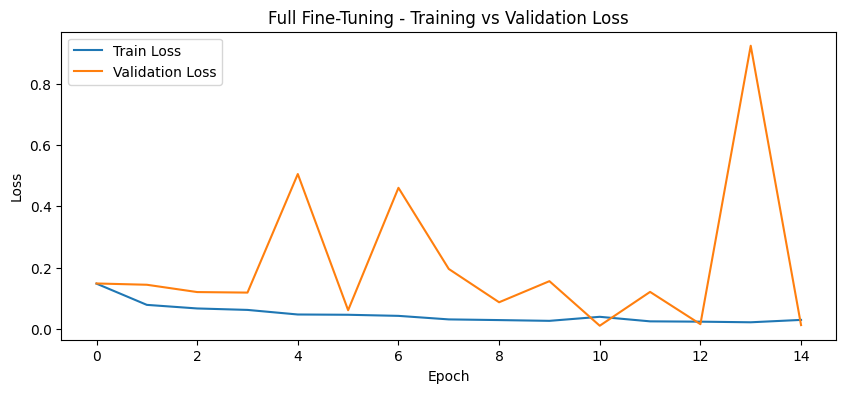

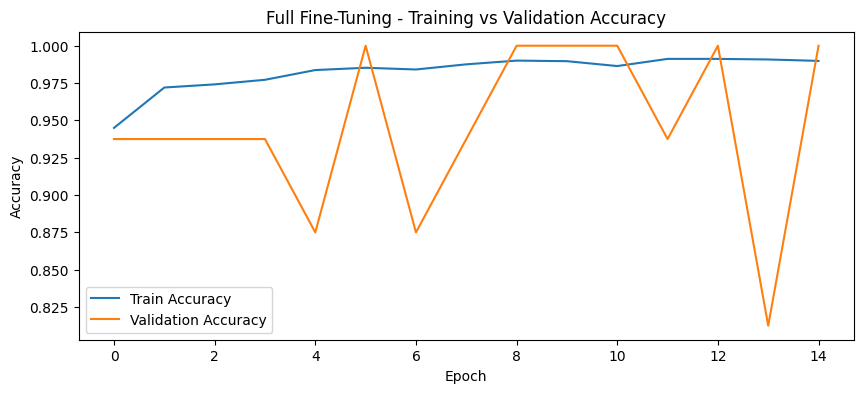

In [19]:
plt.figure(figsize=(10,4))
plt.plot(train_losses_full, label="Train Loss")
plt.plot(val_losses_full, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Full Fine-Tuning - Training vs Validation Loss")
plt.legend()
plt.show()


plt.figure(figsize=(10,4))
plt.plot(train_accs_full, label="Train Accuracy")
plt.plot(val_accs_full, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Full Fine-Tuning - Training vs Validation Accuracy")
plt.legend()
plt.show()

In [20]:
resnet.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = resnet(images)
        _, predicted = torch.max(outputs, 1)
        all_labels_full.extend(labels.cpu().numpy())
        all_preds_full.extend(predicted.cpu().numpy())

test_acc_full = sum(np.array(all_labels_full) == np.array(all_preds_full)) / len(all_labels_full)
print(f"Test Accuracy (Full Fine-Tuning): {test_acc_full*100:.2f}%")



Test Accuracy (Full Fine-Tuning): 93.11%


## Confusion Matrix + Classification Report

              precision    recall  f1-score   support

      NORMAL       0.97      0.84      0.90       234
   PNEUMONIA       0.91      0.98      0.95       390

    accuracy                           0.93       624
   macro avg       0.94      0.91      0.92       624
weighted avg       0.93      0.93      0.93       624



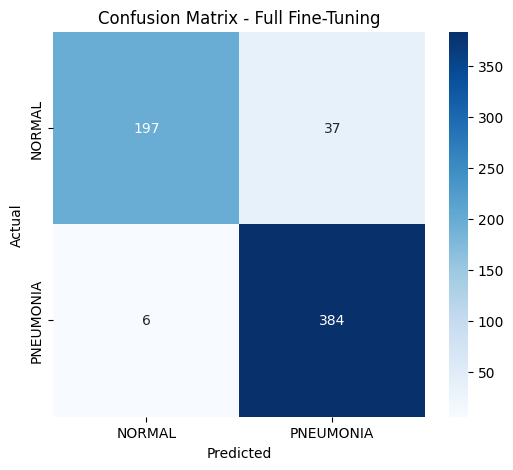

In [21]:
cm = confusion_matrix(all_labels_full, all_preds_full)
print(classification_report(all_labels_full, all_preds_full, target_names=class_names))

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=class_names, yticklabels=class_names, cmap="Blues")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.title("Confusion Matrix - Full Fine-Tuning")
plt.show()

# STEP 3: Perform partial fine-tuning (e.g., on later layers only), then evaluate.

## Freeze early layers, unfreeze later layers

In [22]:
# 1️ Freeze everything
for param in resnet.parameters():
    param.requires_grad = False

# 2️ Unfreeze last block (layer4)
for param in resnet.layer4.parameters():
    param.requires_grad = True

# 3️ Unfreeze classifier
for param in resnet.fc.parameters():
    param.requires_grad = True


## Optimizer ONLY FOR PARTIAL LAYERS

In [23]:
params_to_update = [param for param in resnet.parameters() if param.requires_grad]
optimizer = optim.Adam(params_to_update, lr=1e-4)


## Training Loop (Partial Fine-Tuning)

In [24]:
num_epochs = 15  

train_losses_partial = []
val_losses_partial   = []
train_accs_partial   = []
val_accs_partial     = []

all_labels_partial = []
all_preds_partial  = []
test_acc_partial   = 0.0

for epoch in range(num_epochs):
    
    resnet.train()
    running_loss, correct, total = 0.0, 0, 0
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = resnet(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
    epoch_train_loss = running_loss / total
    epoch_train_acc  = correct / total
    train_losses_partial.append(epoch_train_loss)
    train_accs_partial.append(epoch_train_acc)
    
    resnet.eval()
    running_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = resnet(images)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
    epoch_val_loss = running_loss / total
    epoch_val_acc  = correct / total
    val_losses_partial.append(epoch_val_loss)
    val_accs_partial.append(epoch_val_acc)
    
    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Train Loss: {epoch_train_loss:.4f} Acc: {epoch_train_acc:.4f} | "
          f"Val Loss: {epoch_val_loss:.4f} Acc: {epoch_val_acc:.4f}")


Epoch [1/15] Train Loss: 0.0163 Acc: 0.9944 | Val Loss: 0.0141 Acc: 1.0000
Epoch [2/15] Train Loss: 0.0181 Acc: 0.9929 | Val Loss: 0.0177 Acc: 1.0000
Epoch [3/15] Train Loss: 0.0124 Acc: 0.9956 | Val Loss: 0.0137 Acc: 1.0000
Epoch [4/15] Train Loss: 0.0088 Acc: 0.9975 | Val Loss: 0.0393 Acc: 1.0000
Epoch [5/15] Train Loss: 0.0081 Acc: 0.9964 | Val Loss: 0.0040 Acc: 1.0000
Epoch [6/15] Train Loss: 0.0073 Acc: 0.9973 | Val Loss: 0.0228 Acc: 1.0000
Epoch [7/15] Train Loss: 0.0125 Acc: 0.9969 | Val Loss: 0.0123 Acc: 1.0000
Epoch [8/15] Train Loss: 0.0118 Acc: 0.9954 | Val Loss: 0.0319 Acc: 1.0000
Epoch [9/15] Train Loss: 0.0078 Acc: 0.9971 | Val Loss: 0.0099 Acc: 1.0000
Epoch [10/15] Train Loss: 0.0061 Acc: 0.9967 | Val Loss: 0.0191 Acc: 1.0000
Epoch [11/15] Train Loss: 0.0066 Acc: 0.9981 | Val Loss: 0.0026 Acc: 1.0000
Epoch [12/15] Train Loss: 0.0051 Acc: 0.9979 | Val Loss: 0.0057 Acc: 1.0000
Epoch [13/15] Train Loss: 0.0042 Acc: 0.9987 | Val Loss: 0.0048 Acc: 1.0000
Epoch [14/15] Train L

## Evaluation

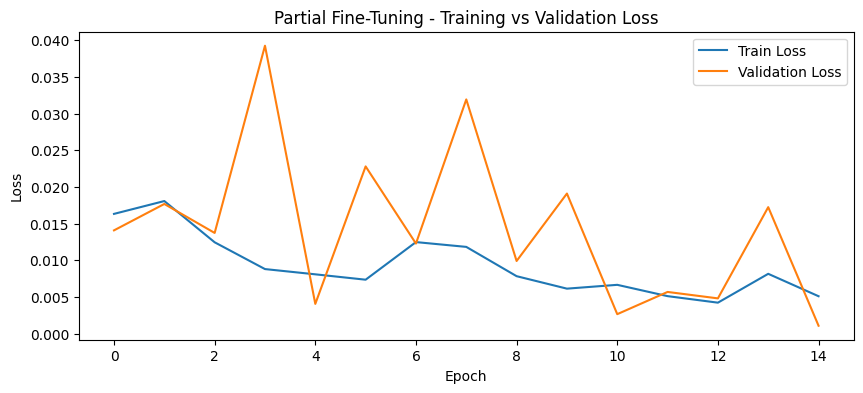

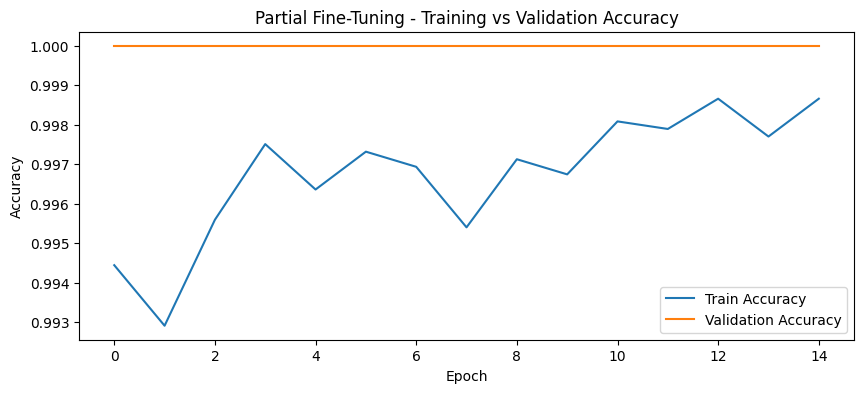

In [25]:
plt.figure(figsize=(10,4))
plt.plot(train_losses_partial, label="Train Loss")
plt.plot(val_losses_partial, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Partial Fine-Tuning - Training vs Validation Loss")
plt.legend()
plt.show()

plt.figure(figsize=(10,4))
plt.plot(train_accs_partial, label="Train Accuracy")
plt.plot(val_accs_partial, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Partial Fine-Tuning - Training vs Validation Accuracy")
plt.legend()
plt.show()

In [26]:
resnet.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = resnet(images)
        _, predicted = torch.max(outputs, 1)
        all_labels_partial.extend(labels.cpu().numpy())
        all_preds_partial.extend(predicted.cpu().numpy())

test_acc_partial = sum(np.array(all_labels_partial) == np.array(all_preds_partial)) / len(all_labels_partial)
print(f"Test Accuracy (Partial Fine-Tuning): {test_acc_partial*100:.2f}%")

Test Accuracy (Partial Fine-Tuning): 91.99%


              precision    recall  f1-score   support

      NORMAL       0.96      0.82      0.88       234
   PNEUMONIA       0.90      0.98      0.94       390

    accuracy                           0.92       624
   macro avg       0.93      0.90      0.91       624
weighted avg       0.92      0.92      0.92       624



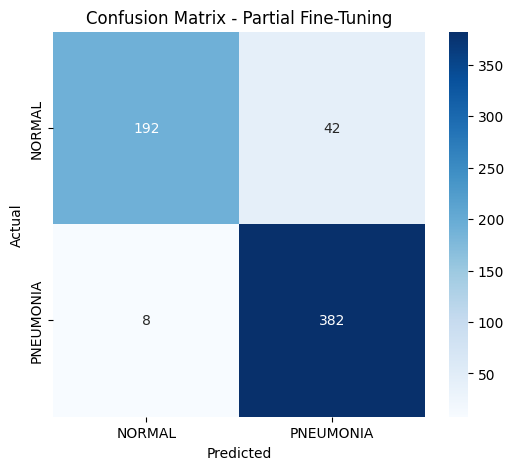

In [27]:
cm = confusion_matrix(all_labels_partial, all_preds_partial)
print(classification_report(all_labels_partial, all_preds_partial, target_names=class_names))

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=class_names, yticklabels=class_names, cmap="Blues")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.title("Confusion Matrix - Partial Fine-Tuning")
plt.show()

# STEP 4:Deliver a comparative analysis detailing the performance, resource usage, and trade-offs of the three strategies.

=== Comparative Analysis Summary ===
                   Strategy  Test Accuracy  Final Train Loss  Final Val Loss  \
0  Frozen Feature Extractor       0.857372          0.179039        0.436543   
1          Full Fine-Tuning       0.931090          0.030056        0.013105   
2       Partial Fine-Tuning       0.919872          0.005090        0.001065   

   Overfit Gap  
0     0.055406  
1    -0.010161  
2    -0.001342  


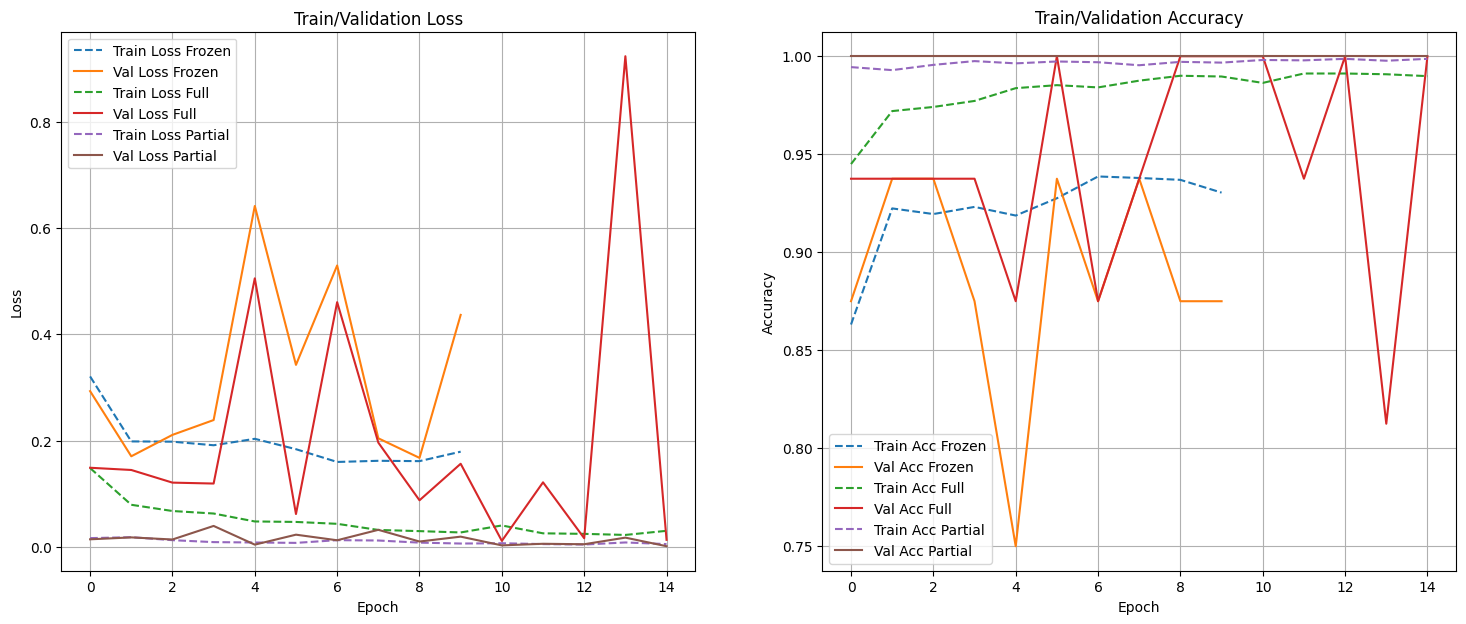

Frozen Feature Extractor:
  Test Accuracy = 0.8574
  Final Train Loss = 0.1790
  Final Val Loss = 0.4365
  Overfit Gap = 0.0554
  Note: Fastest training, lowest resource usage, may underfit new data.

Full Fine-Tuning:
  Test Accuracy = 0.9311
  Final Train Loss = 0.0301
  Final Val Loss = 0.0131
  Overfit Gap = -0.0102
  Note: Highest accuracy, full model adaptation, but slowest and most GPU intensive.

Partial Fine-Tuning:
  Test Accuracy = 0.9199
  Final Train Loss = 0.0051
  Final Val Loss = 0.0011
  Overfit Gap = -0.0013
  Note: Balanced approach, moderate accuracy and resource usage.



In [28]:
strategies = ['Frozen Feature Extractor', 'Full Fine-Tuning', 'Partial Fine-Tuning']
test_accuracies = [test_acc_frozen, test_acc_full, test_acc_partial]

final_train_loss = [train_losses_frozen[-1], train_losses_full[-1], train_losses_partial[-1]]
final_val_loss   = [val_losses_frozen[-1], val_losses_full[-1], val_losses_partial[-1]]

final_train_acc = [train_accs_frozen[-1], train_accs_full[-1], train_accs_partial[-1]]
final_val_acc   = [val_accs_frozen[-1], val_accs_full[-1], val_accs_partial[-1]]
overfit_gap = [t - v for t, v in zip(final_train_acc, final_val_acc)]

summary_df = pd.DataFrame({
    'Strategy': strategies,
    'Test Accuracy': test_accuracies,
    'Final Train Loss': final_train_loss,
    'Final Val Loss': final_val_loss,
    'Overfit Gap': overfit_gap
})

print("=== Comparative Analysis Summary ===")
print(summary_df)

plt.figure(figsize=(18,7))

plt.subplot(1,2,1)
plt.plot(train_losses_frozen, label='Train Loss Frozen', linestyle='--')
plt.plot(val_losses_frozen, label='Val Loss Frozen', linestyle='-')
plt.plot(train_losses_full, label='Train Loss Full', linestyle='--')
plt.plot(val_losses_full, label='Val Loss Full', linestyle='-')
plt.plot(train_losses_partial, label='Train Loss Partial', linestyle='--')
plt.plot(val_losses_partial, label='Val Loss Partial', linestyle='-')
plt.title('Train/Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1,2,2)
plt.plot(train_accs_frozen, label='Train Acc Frozen', linestyle='--')
plt.plot(val_accs_frozen, label='Val Acc Frozen', linestyle='-')
plt.plot(train_accs_full, label='Train Acc Full', linestyle='--')
plt.plot(val_accs_full, label='Val Acc Full', linestyle='-')
plt.plot(train_accs_partial, label='Train Acc Partial', linestyle='--')
plt.plot(val_accs_partial, label='Val Acc Partial', linestyle='-')
plt.title('Train/Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.show()

for i, acc in enumerate(test_accuracies):
    if i == 0:
        note = "Fastest training, lowest resource usage, may underfit new data."
    elif i == 1:
        note = "Highest accuracy, full model adaptation, but slowest and most GPU intensive."
    else:
        note = "Balanced approach, moderate accuracy and resource usage."
    
    print(f"{strategies[i]}:\n"
          f"  Test Accuracy = {acc:.4f}\n"
          f"  Final Train Loss = {final_train_loss[i]:.4f}\n"
          f"  Final Val Loss = {final_val_loss[i]:.4f}\n"
          f"  Overfit Gap = {overfit_gap[i]:.4f}\n"
          f"  Note: {note}\n")
